In [1]:
import os
import torch
import torch_geometric
torch_geometric.__version__

'2.5.3'

# 1.1 Implementation of GraphSAGE

## GNN Stack Module

Below is the implementation of a general GNN stack, a plugin for GNN layer. Your implementation of the **GraphSage** and **GAT** layer will function as a component in the GNNStack Module.

In [2]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

### GraphSage Implementation

For a given *central* node $v$ with current embedding $h_v^{l-1}$, the message passing update rule to tranform $h_v^{l-1} \rightarrow h_v^l$ is as follows:

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

where $W_1$ and $W_2$ are learanble weight matrices and the nodes $u$ are *neighboring* nodes. Additionally, we use mean aggregation for simplicity:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

One thing to note is that we're adding a **skip connection** to our GraphSage implementation through the term $W_l\cdot h_v^{(l-1)}$.

Lastly, $\ell$-2 normalization of the node embeddings is applied after each iteration.

In [3]:
from torch_scatter import scatter

# TODO: Change `__init__`, `forward`, `message`, `aggregate` and `update`
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        ############# Your code here #############
        # Define the (PyTorch) layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated
        #            message from neighbors.

        self.lin_l = nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = nn.Linear(in_channels, out_channels, bias=bias)

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""
 
        out = None

        ############# Your code here #############
        # Implement message passing, as well as any post-processing.
        # 1. Call the propagate function to conduct the message passing.
        #    1.1 See the description of propagate above or the following link for more information:
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We will only use the representation for neighbor nodes (x_j), so by default
        #        we pass the same representation for central and neighbor nodes as x=(x, x).
        # 2. Post-processing: Optional l2-normalization

        out = self.propagate(edge_index, x=(x, x))

        if self.normalize:
            out = F.normalize(out)
        
        ############################################################################

        return out

    def message(self, x_j):

        ############# Your code here #############
        # Implement your message function here.
        # Hint: Look at the formulation of the mean aggregation function, focusing on
        # what message each neighboring node passes.
        out = x_j
        
        ############################################################################
        
        return out

    def aggregate(self, inputs, index, dim_size = None):

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############# Your code here #############
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter:
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter

        #print(inputs, index, dim_size)
        out = torch_scatter.scatter(inputs, index, node_dim)


        #print(out)

        ############################################################################

        return out

    def update(self, inputs, x):

        ############# Your code here #############
        # Implement your update function here.

        #print('x:', x, 'in', inputs)
        
        x_out = self.lin_l(x[0])
        aggr = self.lin_r(inputs)

        out = x_out + aggr
        
        return out


## Building Optimizers

In [4]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

### Training and Testing Setup

In [5]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):

    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes,
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])

    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)

        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


### Training

We will be working on the CORA dataset on node-level classification.

/vol/fob-vol7/mi18/heitmanf/.conda/envs/graphml/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 65.08Epochs/s]


Maximum test set accuracy: 0.796
Minimum loss: 0.07898500561714172



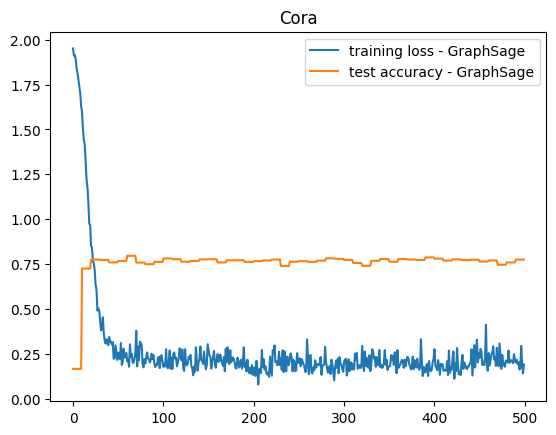

In [6]:

for args in [
    {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
]:
    args = objectview(args)
    for model in ['GraphSage']:
        args.model_type = model

        if args.dataset == 'cora':
            dataset = Planetoid(root='/tmp/cora', name='Cora')
        else:
            raise NotImplementedError("Unknown dataset")
        test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

        print("Maximum test set accuracy: {0}".format(max(test_accs)))
        print("Minimum loss: {0}".format(min(losses)))

        # Run test for our best model to save the predictions!
        test(test_loader, best_model, is_validation=False, save_model_preds=False, model_type=model)
        print()

        plt.title(dataset.name)
        plt.plot(losses, label="training loss" + " - " + args.model_type)
        plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
    plt.legend()
    plt.show()


## Question 1: What is the maximum accuracy obtained on the test set for GraphSage?

Answer 1:

## Question 2: Describe the cora dataset. What type of network is it and what classification do we learn? What input features are used for the training?

Answer 2:

## Question 3: What is the dimension of the output of `message`, `aggregate` and `update`?

Answer 3:

# 1.2 Implementation of GAT

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function. Let $N$ be the number of nodes and $F$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.

We will now describe how this transformation is performed for each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node.

Next, we perform self-attention on the nodes. We use a shared attention function $a$:
\begin{equation}
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

that computes the attention coefficients capturing the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}

The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. However, to utilize graph structure in the attention mechanisms, we use **masked attention**. In masked attention, we only compute attention coefficients $e_{ij}$ for nodes $j \in N_i$ where $N_i$ is some neighborhood of node $i$ in the graph.

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in N_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vectors $\overrightarrow{a_l} \in \mathbb{R}^{F'}$ and $\overrightarrow{a_r} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in N_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

For the following questions, we denote `alpha_l` = $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...] \in R^n$ and `alpha_r` = $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...] \in R^n$.


At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in N_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

### Multi-Head Attention
To stabilize the learning process of self-attention, we use multi-head attention. To do this we use $K$ independent attention mechanisms, or ``heads`` compute output features as in the above equations. Then, we concatenate these output feature representations:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in N_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

where $||$ is concentation, $\alpha_{ij}^{(k)}$ are the normalized attention coefficients computed by the $k$-th attention mechanism $(a^k)$, and $\mathbf{W}^{(k)}$ is the corresponding input linear transformation's weight matrix. Note that for this setting, $\mathbf{h'} \in \mathbb{R}^{KF'}$.

#### Not the following hints for the implementation:

- Hint 1: Our aggregation is very similar to that of GraphSage except now we are using sum aggregation
- Hint 2: The terms we aggregate over again represent the individual message that each neighbor node j sends. Thus, we see that $\alpha_{ij}$ is part of the message each node sends and is thus computed during the message step. This makes sense since an attention weight is associated with each edge in the graph.
- Hint 3: Look at the terms in the definition of $\alpha_{ij}$. What values do we want to pre-process and pass as parameters to the `propagate` function. The parameters of `message(..., x_j, alpha_j, alpha_i, ...)` should give a good hint.
- Hint 4: Note that `update` is missing from the implementation of `propagate`. As a result include the update logic into `propagate` directly. 

In [21]:
# TODO: Change `__init__`, `forward`, `message` and `aggregate`
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############# Your code here #############
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings
        # before message passing.
        # Pay attention to dimensions of the linear layers, since we're using
        # multi-head attention.
        ############################################################################

        self.lin_l = nn.Linear(in_channels, out_channels*heads)
        self.lin_r = nn.Linear(in_channels, out_channels*heads)

        ############# Your code here #############
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear

        ############################################################################

        self.att_l = nn.Parameter(torch.zeros(heads, out_channels))
        self.att_r = nn.Parameter(torch.zeros(heads, out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):

        H, C = self.heads, self.out_channels

        ############# Your code here #############
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing.
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of [N, H * C].
        x_l = self.lin_l(x)
        x_l = torch.stack(x_l.chunk(H, dim=1))
        x_r = self.lin_r(x)
        x_r = torch.stack(x_r.chunk(H, dim=1))
        alpha_l = torch.matmul(self.att_l, x_l)
        alpha_r = (x_r * self.att_r)
        print(alpha_l.size())
        out = self.propagate(edge_index, alpha=(alpha_l, alpha_r))
        #4-

        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############# Your code here #############
        # Implement your message function.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape [E, H, C].
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # 6. size_i: corresponds to the num_nodes variable input to the torch.geometric.softmax method

        out = None

        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############# Your code here #############
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.

        out = None
        
        ############################################################################

        return out

### Training

In [ ]:
for args in [
    {'model_type': 'GAT', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
]:
    args = objectview(args)
    for model in ['GAT']:
        args.model_type = model

        # Match the dimension.
        if model == 'GAT':
          args.heads = 2
        else:
          args.heads = 1

        if args.dataset == 'cora':
            dataset = Planetoid(root='/tmp/cora', name='Cora')
        else:
            raise NotImplementedError("Unknown dataset")
        test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

        print("Maximum test set accuracy: {0}".format(max(test_accs)))
        print("Minimum loss: {0}".format(min(losses)))

        # Run test for our best model to save the predictions!
        test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
        print()

        plt.title(dataset.name)
        plt.plot(losses, label="training loss" + " - " + args.model_type)
        plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
    plt.legend()
    plt.show()


/vol/fob-vol7/mi18/heitmanf/.conda/envs/graphml/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000



Training:   0%|                                                                                                                                                                               | 0/500 [00:00<?, ?Epochs/s]

#### Question 4: What is the maximum accuracy obtained on test set for GAT?

Answer 4:

## Question 5: What is the resulting accuracy if you increase the head count to 4?

Hint: This is done by either modifying `heads` for the current args or adding another args-file. Note, that all other training arguments should not be changed.

Answer 5: